# 基于1维稠密神经网络的故障诊断

- DE - 驱动端加速度计数据
- FE - 风扇端加速度计数据
- BA - 基座加速度计数据
- time - 时间序列数据
- RPM - 转每分钟

In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../data/0HP/12k_1797_10c.csv')
data.head()

,DE_normal,DE_7_inner,DE_7_ball,DE_7_outer,DE_14_inner,DE_14_ball,DE_14_outer,DE_21_inner,DE_21_ball,DE_21_outer
0,0.053197,-0.083004,-0.002761,0.008528,-0.223836,-0.467813,0.002274,1.189431,-0.007959,0.104365
1,0.088662,-0.195734,-0.096324,0.423550,-0.209541,0.179004,-0.104948,-0.177866,0.025340,0.017462
2,0.099718,0.233419,0.113705,0.012995,0.345337,0.481295,0.082010,-0.774816,0.000162,0.116547
3,0.058621,0.103958,0.257297,-0.265175,0.158862,-0.158212,0.094027,0.501518,0.092913,0.371164
4,-0.004590,-0.181115,-0.058314,0.237155,-0.206617,-0.326819,-0.160081,0.993697,-0.007797,0.356951


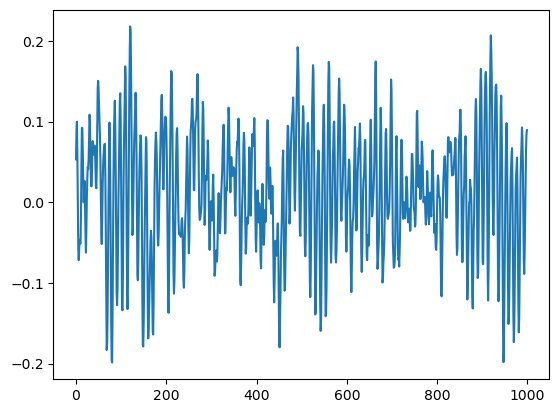

In [3]:
import matplotlib.pyplot as plt
plt.plot(data['DE_normal'][:1000])

In [4]:
SEGMENT_SIZE = 1024  # 每段样本长度
OVERLAP_RATE = 0.3 # 重叠率30%（平衡样本量与信息量）
TRAIN_RATIO = 0.7    # 训练集比例

DATA_CONFIG = [
    ('DE_normal', 0, '正常'),
    ('DE_7_inner', 1, '内圈0.007'),
    ('DE_7_ball', 2, '滚动体0.007'),
    ('DE_7_outer', 3, '外圈0.007'),
    ('DE_14_inner', 4, '内圈0.014'),
    ('DE_14_ball', 5, '滚动体0.014'),
    ('DE_14_outer', 6, '外圈0.014'),
    ('DE_21_inner', 7, '内圈0.021'),
    ('DE_21_ball', 8, '滚动体0.021'),
    ('DE_21_outer', 9, '外圈0.021'),
]

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
class DataPreprocessor:
    def __init__(self, data, segment_size=SEGMENT_SIZE, overlap_rate=OVERLAP_RATE, train_ratio=TRAIN_RATIO):
        self.data = data
        self.segment_size = segment_size
        self.overlap_rate = overlap_rate
        self.train_ratio = train_ratio
        self.segments = []
        self.labels = []

    def segment_data(self):
        step_size = int(self.segment_size * (1 - self.overlap_rate))
        for column_name, label, _ in DATA_CONFIG:
            signal = self.data[column_name].values
            for start in range(0, len(signal) - self.segment_size + 1, step_size):
                segment = signal[start:start + self.segment_size]
                self.segments.append(segment)
                self.labels.append(label)

    def get_train_test_split(self):
        segments = np.array(self.segments)
        labels = np.array(self.labels)
        X_train, X_test, y_train, y_test = train_test_split(
            segments, labels, train_size=self.train_ratio, random_state=42, stratify=labels
        )
        return X_train, y_train, X_test, y_test
    
    def normalize_segments(self, X_train, X_test):
        # 将训练数据重塑为2D以便标准化
        X_train_2d = X_train.reshape(-1, 1)
        # 拟合标准化器
        scaler = StandardScaler()
        scaler.fit(X_train_2d)
        
        # 标准化训练集
        X_train_normalized = scaler.transform(X_train_2d).reshape(X_train.shape)
        
        # 使用训练集的标准化参数标准化测试集
        X_test_2d = X_test.reshape(-1, 1)
        X_test_normalized = scaler.transform(X_test_2d).reshape(X_test.shape)
        
        return X_train_normalized, X_test_normalized
    
    def array2tensor(self, X, y, train):
        X_tensor = torch.FloatTensor(X).unsqueeze(1)  # 添加通道维度[N, 1, 1024]
        y_tensor = torch.LongTensor(y)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        if train:
            loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        else:
            loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        return loader

    def main(self):
        self.segment_data()
        X_train, y_train, X_test, y_test = self.get_train_test_split()
        X_train, X_test = self.normalize_segments(X_train, X_test)
        train_loader = self.array2tensor(X_train, y_train, train=True)
        test_loader = self.array2tensor(X_test, y_test, train=False)
        return train_loader, test_loader

In [6]:
import scipy
import sklearn
print(scipy.__version__)
print(sklearn.__version__)

1.11.4
1.6.1


In [7]:
import torch
import torch.nn as nn
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        )
    
    def forward(self, x):
        new_features = self.layer(x)
        return torch.cat([x, new_features], 1)  # 通道维度拼接
    
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        layers = []
        channels = in_channels
        for _ in range(num_layers):
            layers.append(DenseLayer(channels, growth_rate))
            channels += growth_rate
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)
    
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool1d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        return self.features(x)

class DenseNet1D(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 24, 16), num_classes=10):
        super(DenseNet1D, self).__init__()
        num_init_features = 64
        
        # 初始卷积层
        self.features = nn.Sequential(
            nn.Conv1d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )
        
        # Dense blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_features, growth_rate, num_layers)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionLayer(num_features, num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2
        
        # 分类器
        self.features.add_module('norm5', nn.BatchNorm1d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)
        
        # 权重初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.features(x)
        out = nn.ReLU(inplace=True)(features)
        out = nn.AdaptiveAvgPool1d(1)(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [8]:
import time
from sklearn.metrics import confusion_matrix, classification_report
class TrainEvaluate:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device, epochs, scheduler):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.scheduler = scheduler
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for _, (inputs, targets) in enumerate(self.train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(self.train_loader)
        train_accuracy = 100. * correct / total

        return train_loss, train_accuracy
    
    def evaluate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
            
        eval_loss = running_loss / len(self.test_loader)
        eval_accuracy = 100. * correct / total

        return eval_loss, eval_accuracy, np.array(all_predictions), np.array(all_targets)
    
    def train_evaluate(self):
        best_accuracy = 0.0
        train_losses, train_accs, test_losses, test_accs = [], [], [], []
        for epoch in range(self.epochs):
            start_time = time.time()

            train_loss, train_accuracy = self.train_epoch()
            eval_loss, eval_accuracy, predictions, targets = self.evaluate_epoch()

            train_losses.append(train_loss)
            train_accs.append(train_accuracy)
            test_losses.append(eval_loss)
            test_accs.append(eval_accuracy)

            self.scheduler.step(eval_accuracy) # 学习率调度

            if eval_accuracy > best_accuracy:
                best_accuracy = eval_accuracy
                torch.save(self.model.state_dict(), "../model/1DDenseNet.pth")

            elapsed = time.time() - start_time
    
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}] "
                f"Train Loss: {train_loss:.4f} Acc: {train_accuracy:.2f}% | "
                f"Test Loss: {eval_loss:.4f} Acc: {eval_accuracy:.2f}% | "
                f"Time: {elapsed:.2f}s")
            
        self.training_curves(train_losses, test_losses, train_accs, test_accs)
        confusion_matrix(targets, predictions)
        print(classification_report(targets, predictions, target_names=[name for _, _, name in DATA_CONFIG]))
    
    def training_curves(self, train_losses, test_losses, train_accs, test_accs):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(test_losses, label='Test Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Loss Curves')
        ax1.grid(True)
        ax2.plot(train_accs, label='Train Acc')
        ax2.plot(test_accs, label='Test Acc')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.set_title('Accuracy Curves')
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

Epoch [1/100] Train Loss: 1.7203 Acc: 38.38% | Test Loss: 1.7891 Acc: 32.93% | Time: 19.84s
Epoch [10/100] Train Loss: 0.0448 Acc: 99.48% | Test Loss: 0.0149 Acc: 100.00% | Time: 11.10s
Epoch [20/100] Train Loss: 0.0520 Acc: 98.88% | Test Loss: 0.0364 Acc: 98.80% | Time: 11.38s
Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Epoch [30/100] Train Loss: 0.0201 Acc: 99.48% | Test Loss: 0.0068 Acc: 99.80% | Time: 11.92s
Epoch 00032: reducing learning rate of group 0 to 2.5000e-04.
Epoch [40/100] Train Loss: 0.0107 Acc: 99.91% | Test Loss: 0.0015 Acc: 100.00% | Time: 11.62s
Epoch 00043: reducing learning rate of group 0 to 1.2500e-04.
Epoch [50/100] Train Loss: 0.0298 Acc: 99.83% | Test Loss: 0.0019 Acc: 100.00% | Time: 11.62s
Epoch 00054: reducing learning rate of group 0 to 6.2500e-05.
Epoch [60/100] Train Loss: 0.0089 Acc: 100.00% | Test Loss: 0.0010 Acc: 100.00% | Time: 11.80s
Epoch 00065: reducing learning rate of group 0 to 3.1250e-05.
Epoch [70/100] Train Loss: 0.0044 A

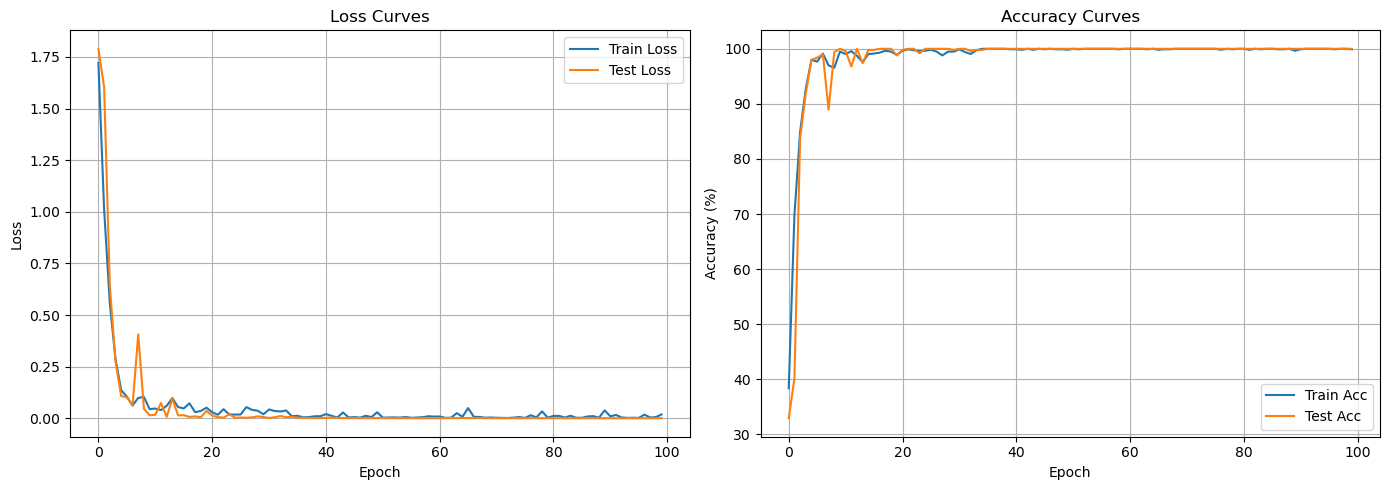

              precision    recall  f1-score   support

          正常       1.00      1.00      1.00        50
     内圈0.007       1.00      1.00      1.00        49
    滚动体0.007       1.00      1.00      1.00        50
     外圈0.007       1.00      1.00      1.00        50
     内圈0.014       1.00      1.00      1.00        50
    滚动体0.014       1.00      1.00      1.00        50
     外圈0.014       1.00      1.00      1.00        50
     内圈0.021       1.00      1.00      1.00        50
    滚动体0.021       1.00      1.00      1.00        49
     外圈0.021       1.00      1.00      1.00        50

    accuracy                           1.00       498
   macro avg       1.00      1.00      1.00       498
weighted avg       1.00      1.00      1.00       498



In [9]:
from torch import optim
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DenseNet1D(num_classes=10).to(device)
    epochs = 100
    preprocessor = DataPreprocessor(data)
    train_loader, test_loader = preprocessor.main()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    train_evaluater = TrainEvaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs, scheduler)
    train_evaluater.train_evaluate()

if __name__ == "__main__":
    main()